Visualizing K Neaerest Neighbor (KNN) Algorithm to identify elbow point for optimal K value (i.e. optimal distance for DBSCAN eps parameter)

In [1]:
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage import uniform_filter1d
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN, HDBSCAN
import numpy as np
import geopandas as gpd 
import os
import pandas as pd 
from shapely import concave_hull, convex_hull, segmentize, minimum_rotated_rectangle
from shapely.ops import nearest_points
# ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
sample_size = 3

In [3]:
def polygon_distance(polygon1, polygon2):
    # Calculate the minimum distance between two polygons
    point1, point2 = nearest_points(polygon1, polygon2)
    return point1.distance(point2)

def compute_distance_matrix(polygons):
    # Create a distance matrix between all polygons
    num_polygons = len(polygons)
    distance_matrix = np.zeros((num_polygons, num_polygons))
    
    for i in range(num_polygons):
        for j in range(i + 1, num_polygons):
            distance_matrix[i, j] = polygon_distance(polygons[i], polygons[j])
            distance_matrix[j, i] = distance_matrix[i, j]  # Symmetry
    
    return distance_matrix

In [4]:
data_dir = r'D:\Projects\superparcels\data\Urban\Alameda_CA'
parcels = gpd.read_file(os.path.join(data_dir, 'sp_sample_06001_cluster_canidates.shp'))
utm = parcels.estimate_utm_crs().to_epsg()

In [5]:
parcels = parcels.to_crs(epsg=utm)  

In [6]:
unique_owners = parcels['OWNER'].unique()
print('Number of unique owners:', len(unique_owners))   

Number of unique owners: 38644


Owner: COLEMANFOLEY


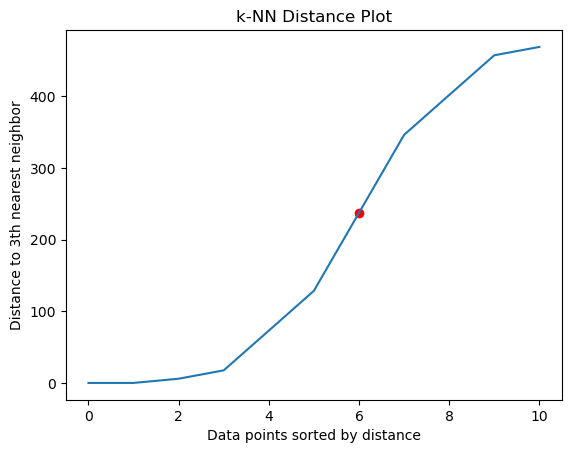

In [7]:
for owner in unique_owners:
    if owner != 'COLEMANFOLEY':
        continue
    print('Owner:', owner)
    owner_parcels = parcels[parcels['OWNER'] == owner]
    polygons = owner_parcels['geometry'].to_list()
    distance_matrix = compute_distance_matrix(polygons)

    # Assuming distance_matrix is the precomputed distance matrix
    neighbors = NearestNeighbors(n_neighbors=sample_size, metric='precomputed')
    neighbors_fit = neighbors.fit(distance_matrix)

    distances, indices = neighbors_fit.kneighbors(distance_matrix)

    # Sort distances to the k-th nearest neighbor
    sorted_distances = np.sort(distances[:, sample_size-1])
    smooth_dist = uniform_filter1d(sorted_distances, size=10)
    difference = np.diff(smooth_dist)
    elbow_index = np.argmax(difference) + 1
    optimal_distance = smooth_dist[elbow_index]
    plt.plot(smooth_dist)
    plt.scatter(elbow_index, optimal_distance, c='r', label='Elbow')
    plt.title('k-NN Distance Plot')
    plt.xlabel('Data points sorted by distance')
    plt.ylabel(f'Distance to {sample_size}th nearest neighbor')
    plt.show()

    break

In [8]:
optimal_distance

237.47791694977695